<a href="https://colab.research.google.com/github/bodadaniel/Dimension_reduction/blob/main/Dimension_reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load packages and load/transform data

In [ ]:
pip install fancyimpute prince

In [53]:
import pandas as pd
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.impute import SimpleImputer
from fancyimpute import KNN, IterativeImputer
from sklearn.preprocessing import OrdinalEncoder
import statsmodels.api as sm
from sklearn.manifold import TSNE
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from prince import MCA
from PIL import Image
import itertools
import random

In [54]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


## Data for selection algos

In [55]:
missing_values = ['.']

file_path = "/gdrive/MyDrive/Colab Notebooks/Dimension_reduction/diabetes.xls"

df = pd.read_csv(file_path, na_values = missing_values)
df.head(2)

,Pregnant,Glucose,Diastolic_BP,Skin_Fold,Serum_Insulin,BMI,Diabetes_Pedigree,Age,Class
0,6.0,148.0,72.0,35.0,NaN,33.6,0.627,50,1.0
1,1.0,85.0,66.0,29.0,NaN,26.6,0.351,31,0.0


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Pregnant           768 non-null    float64
 1   Glucose            763 non-null    float64
 2   Diastolic_BP       733 non-null    float64
 3   Skin_Fold          541 non-null    float64
 4   Serum_Insulin      394 non-null    float64
 5   BMI                757 non-null    float64
 6   Diabetes_Pedigree  768 non-null    float64
 7   Age                768 non-null    int64  
 8   Class              768 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 54.1 KB


In [57]:
df.describe()

,Pregnant,Glucose,Diastolic_BP,Skin_Fold,Serum_Insulin,BMI,Diabetes_Pedigree,Age,Class
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [58]:
df.isna().sum()

Pregnant               0
Glucose                5
Diastolic_BP          35
Skin_Fold            227
Serum_Insulin        374
BMI                   11
Diabetes_Pedigree      0
Age                    0
Class                  0
dtype: int64

In [59]:
#missing ratios
df_miss = pd.DataFrame(df.isna().mean()*100, columns=['missing_rate'])
df_miss

,missing_rate
Pregnant,0.000000
Glucose,0.651042
Diastolic_BP,4.557292
Skin_Fold,29.557292
Serum_Insulin,48.697917
BMI,1.432292
Diabetes_Pedigree,0.000000
Age,0.000000
Class,0.000000


In [60]:
#drop two vars
df2 = df.dropna(subset=['Glucose'], how='any')

In [61]:
df2.isna().sum()

Pregnant               0
Glucose                0
Diastolic_BP          35
Skin_Fold            227
Serum_Insulin        370
BMI                   11
Diabetes_Pedigree      0
Age                    0
Class                  0
dtype: int64

In [ ]:
df2.dropna(subset=['BMI'], how='any', inplace = True)

In [63]:
df2.isna().sum()

Pregnant               0
Glucose                0
Diastolic_BP          28
Skin_Fold            218
Serum_Insulin        360
BMI                    0
Diabetes_Pedigree      0
Age                    0
Class                  0
dtype: int64

In [ ]:
#data imputation, not much focus on that here, more on the topic in missing_data projekt
knn_df2 = df2.copy('deep')
iterative_df2 = df2.copy('deep')

knn_imputer = KNN()
iterative_imputer = IterativeImputer()

knn_df2.iloc[:,:] = knn_imputer.fit_transform(df2)
iterative_df2.iloc[:,:] = iterative_imputer.fit_transform(df2)

## Data for dimension reduction

In [65]:
ansur_missing_values = ['.', 'NaN']

ansur_file_path = "/gdrive/MyDrive/Colab Notebooks/Dimension_reduction/ansur_female_data.csv"

ansur_df = pd.read_csv(ansur_file_path, na_values = ansur_missing_values)
ansur_df.head(2)

,SubjectId,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,...,Branch,PrimaryMOS,SubjectsBirthLocation,SubjectNumericRace,Ethnicity,DODRace,Age,Heightin,Weightlbs,WritingPreference
0,10037,231,1282,301,204,1180,222,177,373,315,...,Combat Support,92Y,Germany,2,NaN,2,26,61,142,Right hand
1,10038,194,1379,320,207,1292,225,178,372,272,...,Combat Service Support,25U,California,3,Mexican,3,21,64,120,Right hand


In [66]:
ansur_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1986 entries, 0 to 1985
Columns: 108 entries, SubjectId to WritingPreference
dtypes: int64(99), object(9)
memory usage: 1.6+ MB


In [67]:
ansur_df.select_dtypes(['object']).head(3)

,Gender,Date,Installation,Component,Branch,PrimaryMOS,SubjectsBirthLocation,Ethnicity,WritingPreference
0,Female,5-Oct-10,Fort Hood,Regular Army,Combat Support,92Y,Germany,NaN,Right hand
1,Female,5-Oct-10,Fort Hood,Regular Army,Combat Service Support,25U,California,Mexican,Right hand
2,Female,5-Oct-10,Fort Hood,Regular Army,Combat Service Support,35D,Texas,NaN,Right hand


In [68]:
ansur_miss_df = pd.DataFrame(ansur_df.isna().sum(), columns=['missing_n'])
ansur_miss_df[ansur_miss_df.missing_n > 0]

,missing_n
Ethnicity,1467


In [69]:
#a lof of category
ansur_df.Ethnicity.nunique()

112

In [70]:
#just drop it simple.
ansur_df.drop(['Ethnicity'], axis = 1, inplace = True)

In [71]:
ansur_df.select_dtypes('object').head(2)

,Gender,Date,Installation,Component,Branch,PrimaryMOS,SubjectsBirthLocation,WritingPreference
0,Female,5-Oct-10,Fort Hood,Regular Army,Combat Support,92Y,Germany,Right hand
1,Female,5-Oct-10,Fort Hood,Regular Army,Combat Service Support,25U,California,Right hand


In [72]:
tips = sns.load_dataset('tips')
tips.head(5)

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [73]:
tips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   total_bill  244 non-null    float64 
 1   tip         244 non-null    float64 
 2   sex         244 non-null    category
 3   smoker      244 non-null    category
 4   day         244 non-null    category
 5   time        244 non-null    category
 6   size        244 non-null    int64   
dtypes: category(4), float64(2), int64(1)
memory usage: 7.4 KB


In [74]:
tips.isna().sum()

total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64

In [75]:
dataset = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/balloons/adult+stretch.data')
dataset.columns = ['Color', 'Size', 'Action', 'Age', 'Inflated']
dataset.head()

,Color,Size,Action,Age,Inflated
0,YELLOW,SMALL,STRETCH,ADULT,T
1,YELLOW,SMALL,STRETCH,CHILD,F
2,YELLOW,SMALL,DIP,ADULT,F
3,YELLOW,SMALL,DIP,CHILD,F
4,YELLOW,LARGE,STRETCH,ADULT,T


In [76]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Color     19 non-null     object
 1   Size      19 non-null     object
 2   Action    19 non-null     object
 3   Age       19 non-null     object
 4   Inflated  19 non-null     object
dtypes: object(5)
memory usage: 888.0+ bytes


In [77]:
dataset.isna().sum()

Color       0
Size        0
Action      0
Age         0
Inflated    0
dtype: int64

In [78]:
image = np.array(Image.open("/gdrive/MyDrive/Colab Notebooks/Dimension_reduction/cat.jpg"))

# Dimension reduction on continuous vars

##TSNE

In [79]:
#exclude two numeric variables
ansur_df = ansur_df.drop(['SubjectNumericRace', 'SubjectId'], axis = 1)

In [80]:
#TSNE with two components, learning rate = 50, perplexity = 30, metric = euclidean
tsne = TSNE(learning_rate = 50)

tsne_data = tsne.fit_transform(ansur_df.select_dtypes(exclude=['object']))

ansur_df2 = ansur_df.copy('deep')

ansur_df2['tsne_1'] = tsne_data[:,0]
ansur_df2['tsne_2'] = tsne_data[:,1]

In [ ]:
#only on numeric features
ansur_df.loc[:, tsne.feature_names_in_ ].info()

In [82]:
ansur_df2.shape, tsne_data.shape

((1986, 107), (1986, 2))

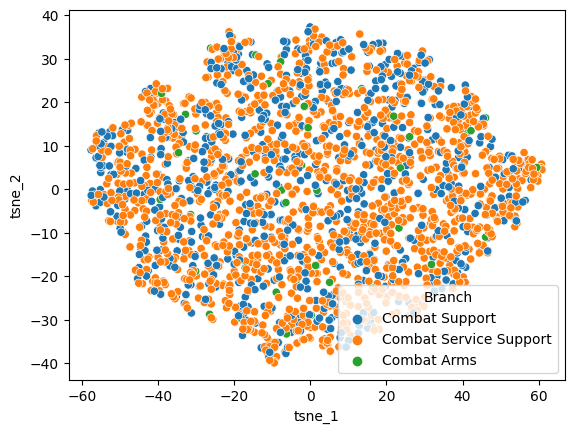

In [83]:
#scatterplots on the components colored by categorical features
sns.scatterplot(x="tsne_1", y="tsne_2", hue='Branch', data=ansur_df2)
plt.show()

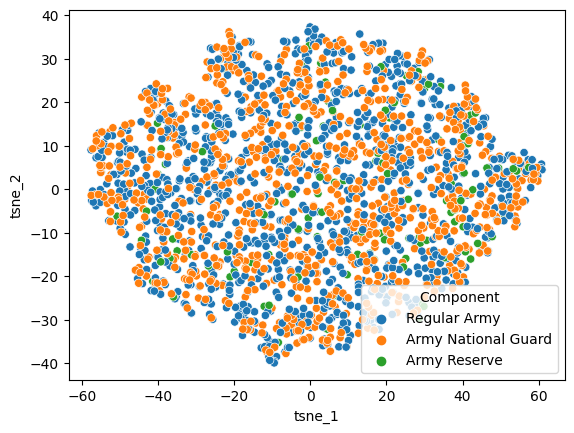

In [84]:
sns.scatterplot(x="tsne_1", y="tsne_2", hue='Component', data=ansur_df2)
plt.show()

##PCA

In [85]:
#transform data and include all numeric features
std_sc = StandardScaler()
ansur_df_std = std_sc.fit_transform(ansur_df.select_dtypes(exclude=['object']))

In [86]:
#PCA with four principle components and check on dimension
pca = PCA(n_components = 4)
pc = pca.fit_transform(ansur_df_std)
ansur_df_std.shape, pc.shape, pca.components_.shape, np.matmul(pc, pca.components_).shape

((1986, 97), (1986, 4), (4, 97), (1986, 97))

In [88]:
#dataframe of explained variance ratio
pd.DataFrame.from_dict(data = {i + 1 : [var1, var2] for i, (var1, var2) \
                       in enumerate(zip(pca.explained_variance_ratio_, pca.explained_variance_ratio_.cumsum()))},
                       orient = 'index',
                       columns = ['explained_variance_ratio_', 'explained_variance_ratio_cumsum'] )

,explained_variance_ratio_,explained_variance_ratio_cumsum
1,0.438370,0.438370
2,0.144765,0.583135
3,0.050967,0.634102
4,0.037067,0.671170


In [89]:
#only two components
pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components = 2))])
pipe.fit( ansur_df.select_dtypes(exclude=['object']) )

comp1_list = list(zip(ansur_df.select_dtypes(exclude=['object']).columns, pipe['pca'].components_[0] ))

comp1_list.sort(key=lambda x: abs(x[1]), reverse = True)
comp1_list[:5]

[('suprasternaleheight', -0.13549389039862703),
 ('buttockkneelength', -0.1354507998886128),
 ('kneeheightsitting', -0.1352867595702909),
 ('sleevelengthspinewrist', -0.13453686509551496),
 ('acromialheight', -0.13250499747869343)]

In [90]:
comp2_list = list(zip(ansur_df.select_dtypes(exclude=['object']).columns, pipe['pca'].components_[1] ))

comp2_list.sort(key=lambda x: abs(x[1]), reverse = True)
comp2_list[:5]

[('waistcircumference', 0.18318184663652606),
 ('abdominalextensiondepthsitting', 0.17655052156497533),
 ('waistdepth', 0.17641980468163107),
 ('chestcircumference', 0.1743645116640311),
 ('waistbreadth', 0.17357960468427522)]

In [ ]:
ansur_ext_df = ansur_df.copy('deep')

ansur_ext_df['pc1'] = pipe['pca'].transform(ansur_df.select_dtypes(exclude=['object']))[:,0]
ansur_ext_df['pc2'] = pipe['pca'].transform(ansur_df.select_dtypes(exclude=['object']))[:,1]

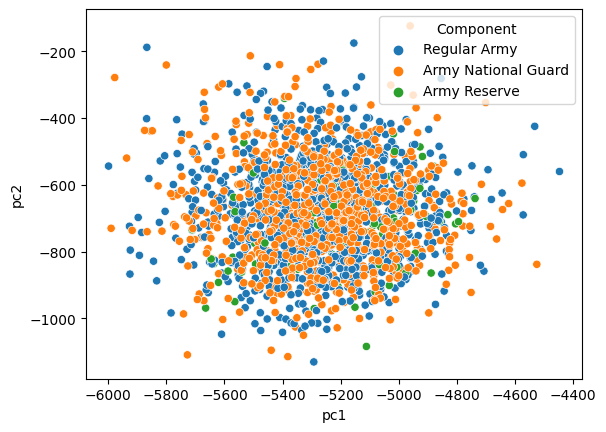

In [56]:
sns.scatterplot(ansur_ext_df, x='pc1', y='pc2',hue='Component');

In [92]:
#define a treshold for keep at least that much variance of the original data in the new features space
pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components = 0.7))])
pipe.fit( ansur_df.select_dtypes(exclude=['object']) )

pipe['pca'].components_.shape

(6, 97)

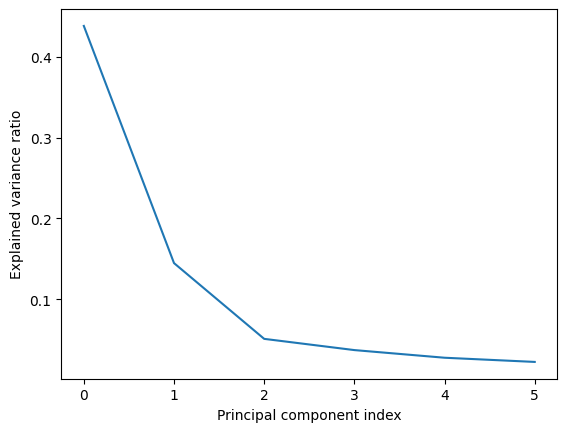

In [93]:
#scree plot
plt.plot(pipe['pca'].explained_variance_ratio_)

plt.xlabel('Principal component index') #index + 1 = number of components
plt.ylabel('Explained variance ratio')
plt.show()

##SVD

Reproduct the original picture using k singular values

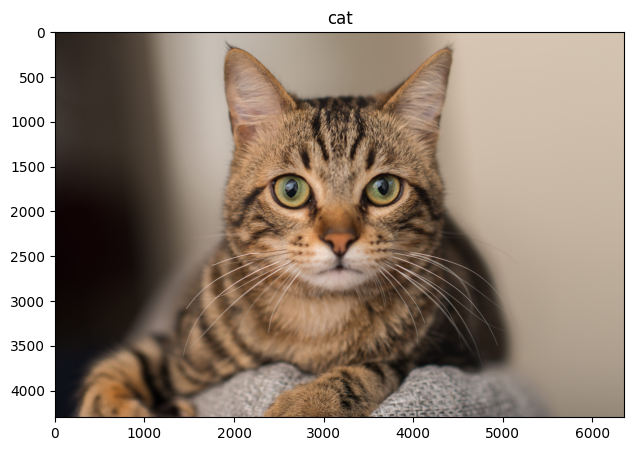

In [94]:
#Plot image
fig = plt.figure(figsize=(10, 5))
imgplot = plt.imshow(image)
plt.title("cat")
plt.show()

In [95]:
#check the shape
print(image.shape)

(4299, 6359, 3)


In [96]:
#get each color components
red = image[:,:,0].astype('float64')
green = image[:,:,1].astype('float64')
blue = image[:,:,2].astype('float64')

In [97]:
#decompose the original color matrices into U, S, V matrices
def svd(input, full = True, full_matrices = True, compute_uv = True, hermitian = False):
  if compute_uv == True:
    return np.linalg.svd(input,
                         full_matrices = full_matrices,
                         compute_uv = compute_uv,
                         hermitian = hermitian)
  else:
    return None, np.linalg.svd(input,
                               full_matrices = full_matrices,
                               compute_uv = compute_uv,
                               hermitian = hermitian), None

In [98]:
#Invoke svd function
U_red, Sigma_red, V_red = svd(input = red,
                              full_matrices = True,
                              compute_uv = True,
                              hermitian = False)

U_green, Sigma_green, V_green = svd(input = green,
                                    full_matrices = True,
                                    compute_uv = True,
                                    hermitian = False)

U_blue, Sigma_blue, V_blue = svd(input = blue,
                                 full_matrices = True,
                                 compute_uv = True,
                                 hermitian = False)

In [99]:
print(U_red.shape)
print(V_red.shape)
print(Sigma_red.shape)

(4299, 4299)
(6359, 6359)
(4299,)


In [100]:
k = 50

#take the first k rows and columns for each component
U_red_k = U_red[:, :k]
V_red_k = V_red[:k, :]

U_green_k = U_green[:, :k]
V_green_k = V_green[:k, :]

U_blue_k = U_blue[:, :k]
V_blue_k = V_blue[:k, :]

#take the first k singular values and transform the vector form to a diagonal matrix
Sigma_red_k = np.diag(Sigma_red[:k])
Sigma_green_k = np.diag(Sigma_green[:k])
Sigma_blue_k = np.diag(Sigma_blue[:k])

print(U_red_k.shape)
print(V_red_k.shape)
print(Sigma_red_k.shape)

(4299, 50)
(50, 6359)
(50, 50)


In [101]:
#reconstruct the color matricies
red_k = U_red_k @ Sigma_red_k @ V_red_k
green_k = U_green_k @ Sigma_green_k @ V_green_k
blue_k = U_blue_k @ Sigma_blue_k @ V_blue_k
print(red_k.shape)
print(green_k.shape)
print(blue_k.shape)

(4299, 6359)
(4299, 6359)
(4299, 6359)


In [102]:
#reconstruct the original 3d matrix of image
reduced_cat = np.zeros((4299, 6359, 3))

reduced_cat[:, :, 0] = red_k
reduced_cat[:, :, 1] = green_k
reduced_cat[:, :, 2] = blue_k

#reduced_cat = reduced_cat.astype('uint8')
reduced_cat = reduced_cat.astype('int')

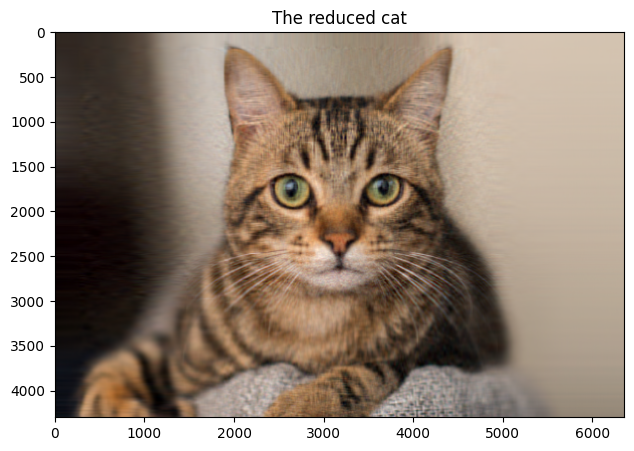

In [103]:
fig = plt.figure(figsize=(10, 5))
plt.imshow(reduced_cat)
plt.title('The reduced cat')
plt.show();

Impute missing data using SVD

In [104]:
image2 = np.copy(image)

In [7]:
#(0,0,255)    blue
#(255,0,0)    red
#(0, 128, 0)  green

def col_dot(input, count, length = 50, color = (255, 0, 0) ):
  """  make some color dot in the original pic """
  pic = np.copy(input)
  pic_float = np.copy(input).astype(float)
  xs = np.arange(0, (pic.shape[0] - length), 1)
  ys = np.arange(0, (pic.shape[1] - length), 1)
  all_coordinates = np.array(list(itertools.product(xs, ys)))
  points = all_coordinates[np.random.choice(np.arange(0, len(all_coordinates), 1), count, replace = False)]
  for point in points:
    pic[point[0]:(point[0] + length), point[1]:(point[1] + length), :] = color
    pic_float[point[0]:(point[0] + length), point[1]:(point[1] + length), :] = np.nan

  return pic, pic_float

image3, image3_float = col_dot(input = image2, count = 3)

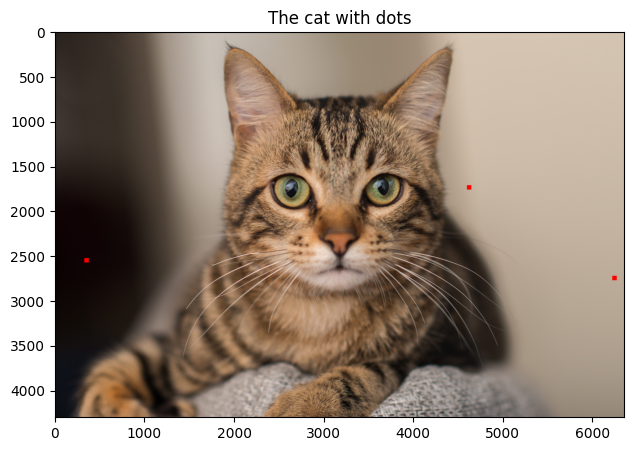

In [8]:
fig = plt.figure(figsize=(10, 5))
plt.imshow(image3.astype('int'))
plt.title('The cat with dots')
plt.show();

In [9]:
#check on missing point
mask = np.isnan(image3_float)
np.sum(mask)

22500

Solution 1

In [26]:
#column average by channel
avg_channel = np.nanmean(image3_float, axis=0, keepdims=True)
np.sum(np.isnan(avg_channel)), avg_channel.shape

(0, (1, 6359, 3))

In [28]:
#normalize data
image3_float_norm = image3_float - avg_channel
print(np.sum(np.isnan(image3_float_norm)))
image3_float_norm[mask] = 0
print(np.sum(np.isnan(image3_float_norm)))

22500
0


In [30]:
(abs(image3_float_norm.mean(axis=0) - 0 ) < 1e-10).all()

True

In [16]:
#get each color components
red = image3_float_norm[:,:,0].astype('float64')
green = image3_float_norm[:,:,1].astype('float64')
blue = image3_float_norm[:,:,2].astype('float64')

In [17]:
U_red, Sigma_red, V_red = svd(input = red,
                              full_matrices = True,
                              compute_uv = True,
                              hermitian = False)

U_green, Sigma_green, V_green = svd(input = green,
                                    full_matrices = True,
                                    compute_uv = True,
                                    hermitian = False)

U_blue, Sigma_blue, V_blue = svd(input = blue,
                                 full_matrices = True,
                                 compute_uv = True,
                                 hermitian = False)

In [18]:
k = 1000

#take the first k rows and columns for each component
U_red_k = U_red[:, :k]
V_red_k = V_red[:k, :]

U_green_k = U_green[:, :k]
V_green_k = V_green[:k, :]

U_blue_k = U_blue[:, :k]
V_blue_k = V_blue[:k, :]

#take the first k singular values and transform the vector form to a diagonal matrix
Sigma_red_k = np.diag(Sigma_red[:k])
Sigma_green_k = np.diag(Sigma_green[:k])
Sigma_blue_k = np.diag(Sigma_blue[:k])


In [19]:
#reconstruct the color matricies
red_k = U_red_k @ Sigma_red_k @ V_red_k
green_k = U_green_k @ Sigma_green_k @ V_green_k
blue_k = U_blue_k @ Sigma_blue_k @ V_blue_k

In [20]:
reduced_cat = np.zeros(image3.shape)

reduced_cat[:, :, 0] = red_k
reduced_cat[:, :, 1] = green_k
reduced_cat[:, :, 2] = blue_k

In [21]:
#add back the shift
reduced_cat = reduced_cat + avg_channel

In [22]:
image3_float_new = np.copy(image3_float)

In [23]:
#replace only missing values
image3_float_new[mask] = reduced_cat[mask]
image3_float_new = image3_float_new.astype('int')

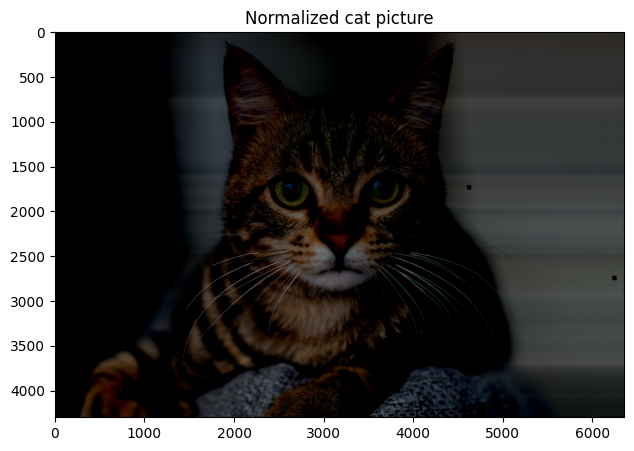

In [24]:
fig = plt.figure(figsize=(10, 5))
plt.imshow(image3_float_norm.astype('int'))
plt.title('Normalized cat picture')
plt.show();

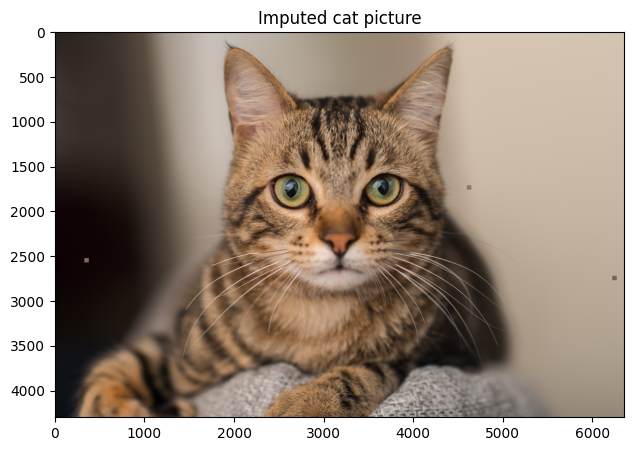

In [25]:
fig = plt.figure(figsize=(10, 5))
plt.imshow(image3_float_new)
plt.title('Imputed cat picture')
plt.show();

Solution 2

In [31]:
#get each color components
red = image3_float[:,:,0].astype('float64')
green = image3_float[:,:,1].astype('float64')
blue = image3_float[:,:,2].astype('float64')

In [32]:
red.shape, red.mean(axis=0, keepdims=True).shape

((4299, 6359), (1, 6359))

In [39]:
#column mean
avg_red =  np.nanmean(red, axis=0, keepdims=True)
avg_green =  np.nanmean(green, axis=0, keepdims=True)
avg_blue =  np.nanmean(blue, axis=0, keepdims=True)

In [38]:
np.sum(np.isnan(avg_red))

0

In [40]:
#center the data and fill missing values with zero
red_norm = red - avg_red
red_norm[np.isnan(red_norm)] = 0

green_norm = green - avg_green
green_norm[np.isnan(green_norm)] = 0

blue_norm = blue - avg_blue
blue_norm[np.isnan(blue_norm)] = 0

np.sum(np.isnan(red_norm)), np.sum(np.isnan(green_norm)), np.sum(np.isnan(blue_norm))

(0, 0, 0)

In [41]:
(abs(red_norm.mean(axis=0) - 0 ) < 1e-5).all()

True

In [42]:
U_red, Sigma_red, V_red = svd(input = red_norm,
                              full_matrices = True,
                              compute_uv = True,
                              hermitian = False)

U_green, Sigma_green, V_green = svd(input = green_norm,
                                    full_matrices = True,
                                    compute_uv = True,
                                    hermitian = False)

U_blue, Sigma_blue, V_blue = svd(input = blue_norm,
                                 full_matrices = True,
                                 compute_uv = True,
                                 hermitian = False)

In [43]:
k = 1000

#take the first k rows and columns for each component
U_red_k = U_red[:, :k]
V_red_k = V_red[:k, :]

U_green_k = U_green[:, :k]
V_green_k = V_green[:k, :]

U_blue_k = U_blue[:, :k]
V_blue_k = V_blue[:k, :]

#take the first k singular values and transform the vector form to a diagonal matrix
Sigma_red_k = np.diag(Sigma_red[:k])
Sigma_green_k = np.diag(Sigma_green[:k])
Sigma_blue_k = np.diag(Sigma_blue[:k])


In [44]:
#reconstruct the color matricies
red_k = U_red_k @ Sigma_red_k @ V_red_k
green_k = U_green_k @ Sigma_green_k @ V_green_k
blue_k = U_blue_k @ Sigma_blue_k @ V_blue_k

In [45]:
#add back
red_k = red_k + avg_red
green_k = green_k + avg_green
blue_k = blue_k + avg_blue

In [46]:
reduced_cat = np.zeros(image3.shape)

reduced_cat[:, :, 0] = red_k
reduced_cat[:, :, 1] = green_k
reduced_cat[:, :, 2] = blue_k

In [49]:
image3_float_new = np.copy(image3_float)

In [50]:
#replace only missing values
image3_float_new[mask] = reduced_cat[mask]
image3_float_new = image3_float_new.astype('int')

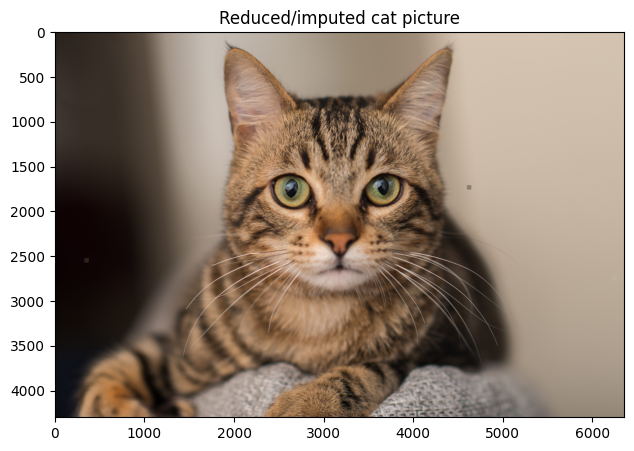

In [48]:
fig = plt.figure(figsize=(10, 5))
plt.imshow(reduced_cat.astype(int))
plt.title('Reduced/imputed cat picture')
plt.show();

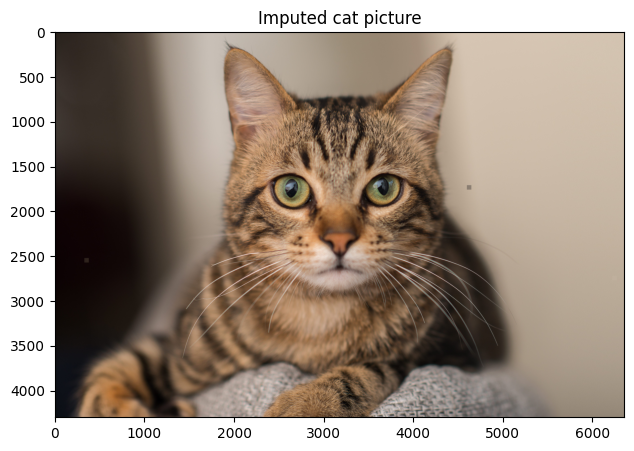

In [51]:
fig = plt.figure(figsize=(10, 5))
plt.imshow(image3_float_new)
plt.title('Imputed cat picture')
plt.show();

#Dimenson reduction on categorical data

In [7]:
tips.dtypes

total_bill     float64
tip            float64
sex           category
smoker        category
day           category
time          category
size             int64
dtype: object

In [8]:
#drop numeric features
tips2 = tips.drop(['total_bill', 'tip', 'size'], axis = 1)

In [17]:
#Fit and transform data with MCA and check on dims
mca = MCA(n_components = 2, n_iter = 3, random_state = 1234)
tips_mca = mca.fit_transform(tips)
tips2.shape, tips_mca.shape

((244, 4), (244, 2))

In [18]:
#Summary
mca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.483,0.94%,0.94%
1,0.391,0.76%,1.69%


In [23]:
#Fit and transform data with MCA and check on dims
mca = MCA(n_components = 2, n_iter = 3, random_state = 1234)
dataset_mca = mca.fit_transform(dataset)
dataset.shape, dataset_mca.shape

((19, 5), (19, 2))

In [24]:
#Summary
mca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.402,40.17%,40.17%
1,0.211,21.11%,61.28%


In [35]:
#MCA transformed dataset = the row coordinates
dataset_mca.equals(mca.row_coordinates(dataset))

True

In [37]:
#One-hot encoded features
mca.column_coordinates(dataset)

,0,1
Color_PURPLE,0.117308,6.892024e-01
Color_YELLOW,-0.130342,-7.657805e-01
Size_LARGE,0.117308,-6.892024e-01
Size_SMALL,-0.130342,7.657805e-01
Action_DIP,-0.853864,4.070625e-16
Action_STRETCH,0.620992,-4.124627e-16
Age_ADULT,0.620992,1.044520e-15
Age_CHILD,-0.853864,-1.616403e-15
Inflated_F,-0.731466,-3.728853e-16
Inflated_T,1.253942,4.607872e-16


In [51]:
pd.get_dummies(dataset).columns == mca.column_coordinates(dataset).index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [ ]:
(np.matmul(pd.get_dummies(dataset), mca.column_coordinates(dataset))).equals(dataset_mca)

In [53]:
mca.plot(dataset, x_component=0, y_component=1)

alt.Chart(...)

# Feature selection

##Correlation

In [135]:
ansur_df3 = ansur_df2.copy('deep')

In [136]:
#correlation on numeric vars
ansur_df3 = ansur_df3.select_dtypes(exclude=['object']).drop(['tsne_1', 'tsne_2'], axis = 1)

In [137]:
#normalize the data
ansur_df3 = ansur_df3 / ansur_df3.mean()

In [64]:
#check the variance of data
def var_sort(df, ascending = True, top = 5):
  return pd.DataFrame(df.var(), columns=(['values'])).sort_values('values', ascending = ascending)[:top]

var_sort(ansur_df3, ascending = True), var_sort(ansur_df3, ascending = False)

(                     values
 headcircumference  0.001191
 headbreadth        0.001234
 sittingheight      0.001489
 headlength         0.001540
 stature            0.001554,
               values
 DODRace     0.314804
 Age         0.082871
 weightkg    0.026281
 Weightlbs   0.024008
 waistdepth  0.021690)

In [94]:
#delete variables with lower-than-treshold variance
var_tr = VarianceThreshold(threshold=0.002)

var_tr.fit(ansur_df3)

mask = var_tr.get_support()
print(f'{len(mask) - sum(mask)} variables deleted.')

ansur_df3 = ansur_df3.loc[:, mask]

11 variables deleted.


In [138]:
#corrs and masking
corr = ansur_df3.corr().abs()
mask = np.triu(np.ones_like(corr, dtype=bool))
corr = corr.mask(mask)
high_corr_var = [c for c in corr.columns if any(corr[c] > 0.95)]

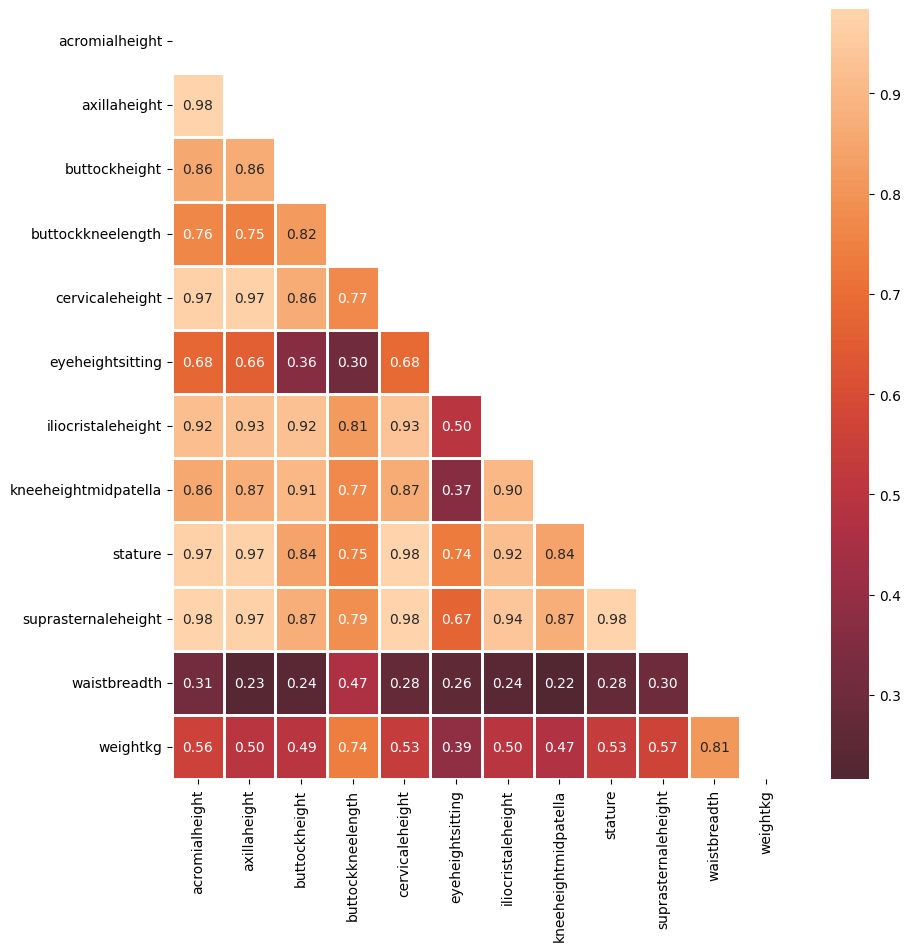

In [141]:
#check on the heatmap of the vars with highest correlation
plt.figure(figsize=(10,10))
sns.heatmap(corr.loc[high_corr_var, high_corr_var],
            mask=np.triu(np.ones_like(corr.loc[high_corr_var, high_corr_var], dtype=bool)),
            center=0,
            linewidths=1,
            annot=True,
            fmt=".2f")
plt.show()

In [122]:
#drop vars (only one of the pairs) with highest correlation
ansur_df3.drop(columns = high_corr_var, axis = 1, inplace = True )

In [123]:
ansur_df2.shape, ansur_df3.shape

((1986, 107), (1986, 79))

##Selection algorithms

###Classification problem

In [105]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(knn_df2.iloc[:,:-1],
                                                    knn_df2.Class,
                                                    test_size=0.33,
                                                    random_state=42)

In [108]:
#standardize vars to compare the model parameters
lr = LogisticRegression()
std_sc = StandardScaler()

lr.fit(std_sc.fit_transform(X_train), y_train)

print(f'Test set accuracy: {lr.score(std_sc.transform(X_test), y_test).round(2)} \
        and coeff: {dict(zip(X_train.columns, abs(lr.coef_[0]).round(2)))}')

Test set accuracy: 0.76         and coeff: {'Pregnant': 0.27, 'Glucose': 0.99, 'Diastolic_BP': 0.02, 'Skin_Fold': 0.27, 'Serum_Insulin': 0.01, 'BMI': 0.42, 'Diabetes_Pedigree': 0.27, 'Age': 0.16}


In [109]:
#select only vars with greater than the treshold
knn_df2 = knn_df2.loc[:, np.append(abs(lr.coef_[0]) > 0.05 , True)]

In [110]:
X_train, X_test, y_train, y_test = train_test_split(knn_df2.iloc[:,:-1],
                                                    knn_df2.Class,
                                                    test_size=0.33,
                                                    random_state=42)

In [111]:
#fit again in lower dimension
lr = LogisticRegression()
std_sc = StandardScaler()

lr.fit(std_sc.fit_transform(X_train), y_train)

print(f'Test set accuracy: {lr.score(std_sc.transform(X_test), y_test).round(2)} \
        and coeff: {dict(zip(X_train.columns, abs(lr.coef_[0]).round(2)))}')

Test set accuracy: 0.76         and coeff: {'Pregnant': 0.28, 'Glucose': 0.99, 'Skin_Fold': 0.27, 'BMI': 0.43, 'Diabetes_Pedigree': 0.27, 'Age': 0.17}


In [114]:
#RFE with LR classifier to decrease the dimension of data into 3 keeping test accuracy as high as possible
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=3, verbose=1)
rfe.fit(X_train, y_train)
print(f'Test set accuracy: {rfe.score(X_test, y_test).round(2)} \
        and vars: {dict(zip(X_train.columns, rfe.support_ ))}')

Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Test set accuracy: 0.69         and vars: {'Pregnant': True, 'Glucose': False, 'Skin_Fold': False, 'BMI': True, 'Diabetes_Pedigree': True, 'Age': False}


In [115]:
#RF classifier on 6 features
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)
print(f'Test set accuracy: {rf.score(X_test, y_test).round(2)} \
        and vars: {dict(zip(X_train.columns, rf.feature_importances_ ))}')

Test set accuracy: 0.77         and vars: {'Pregnant': 0.09188965752041932, 'Glucose': 0.29038064854070716, 'Skin_Fold': 0.1414207825460964, 'BMI': 0.17271966623261947, 'Diabetes_Pedigree': 0.158993813986814, 'Age': 0.1445954311733436}


In [116]:
#keep only the vars which have higher than 0.15 feature importance treshold
mask = rf.feature_importances_ > 0.15

In [117]:
#Better prediction accuracy than LR on 3 features
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train.loc[:, mask ], y_train)

print(f'Test set accuracy: {rf.score(X_test.loc[:, mask ], y_test).round(2)} \
        and vars: {dict(zip(X_train.loc[:, mask ].columns, rf.feature_importances_ ))}')

Test set accuracy: 0.74         and vars: {'Glucose': 0.391135541994733, 'BMI': 0.30757897935893097, 'Diabetes_Pedigree': 0.30128547864633615}


In [118]:
#check ranking attribute
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=2, step=2, verbose=1)

rfe.fit(X_train, y_train)

mask = rfe.support_

print(f'Test set accuracy: {rfe.score(X_test, y_test).round(2)} \
        and vars: {dict(zip(X_train.columns, rfe.ranking_ ))}')

Fitting estimator with 6 features.
Fitting estimator with 4 features.
Test set accuracy: 0.73         and vars: {'Pregnant': 3, 'Glucose': 1, 'Skin_Fold': 3, 'BMI': 1, 'Diabetes_Pedigree': 2, 'Age': 2}


### Regression problem

In [162]:
#Model matrix and response variable
X = ansur_df3.drop(['bicepscircumferenceflexed'], axis = 1)
y = ansur_df3.bicepscircumferenceflexed

In [163]:
#train-test split and dimenions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape

(1330, 96)

In [164]:
#Standardization
std_sc = StandardScaler()
X_train_std = std_sc.fit_transform(X_train)
X_test_std = std_sc.transform(X_test)

In [191]:
#Lasso CV for feature selection
lcv = LassoCV()
lcv.fit(X_train_std, y_train)
print(f'Optimal alpha = {lcv.alpha_:.3f}')

r_squared = lcv.score(X_test_std, y_test)
print(f'The model explains {r_squared:.1%} of the test set variance')

lasso_mask = lcv.coef_ != 0
print(f'{sum(lasso_mask)} features out of {len(lasso_mask)} selected')

print(f'coeffs: {dict(zip(X_train.columns[lasso_mask], lcv.coef_[lasso_mask] ))})')

Optimal alpha = 0.000
The model explains 86.4% of the test set variance
70 features out of 96 selected
coeffs: {'abdominalextensiondepthsitting': 0.0016656060567439542, 'acromionradialelength': 0.0027769003184656207, 'axillaheight': -0.007199193046194296, 'balloffootcircumference': -0.002680898785011064, 'balloffootlength': -0.0011612324269984545, 'biacromialbreadth': -0.008835100801887971, 'bicristalbreadth': -0.0005930896516790593, 'bideltoidbreadth': 0.02147706577348677, 'bimalleolarbreadth': -0.004658676523714609, 'bitragionchinarc': 0.00032775818843268833, 'bitragionsubmandibulararc': -0.0009316795594079356, 'bizygomaticbreadth': -0.0008663613333725617, 'buttockpopliteallength': 0.004623107920100023, 'calfcircumference': -0.0017381513650106932, 'cervicaleheight': -0.005105115831515128, 'chestbreadth': -0.004511308851803461, 'chestdepth': -0.00223112981970059, 'chestheight': 0.0028860954595412405, 'crotchheight': 0.002395599718716724, 'crotchlengthomphalion': -0.009480023202954782,

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.671e-03, tolerance: 1.356e-03
  model = cd_fast.enet_coordinate_descent(


In [192]:
#variables with highest absolute coeffs
result = list(zip(X_train.columns[lasso_mask], lcv.coef_[lasso_mask] ))

result.sort(key=lambda x: abs(x[1]), reverse = True)
result[:5]

[('weightkg', 0.06769544080640591),
 ('forearmcircumferenceflexed', 0.038007670009014394),
 ('bideltoidbreadth', 0.02147706577348677),
 ('kneeheightsitting', -0.011931870937382271),
 ('shoulderelbowlength', -0.011174162419914918)]

In [198]:
#Lasso with regularization, less variable, variance
la = Lasso(alpha=0.01, random_state=0)

la.fit(X_train_std, y_train)
r_squared = la.score(X_test_std, y_test)
print(f'The model can explain {r_squared:.1%} of the variance in the test set')

lasso_mask = la.coef_ != 0
print(f'{sum(lasso_mask)} features out of {len(lasso_mask)} selected')

print(f'coeffs: {dict(zip(X_train.columns[lasso_mask], la.coef_[lasso_mask] ))})')

The model can explain 81.6% of the variance in the test set
12 features out of 96 selected
coeffs: {'abdominalextensiondepthsitting': 0.0020582538907894412, 'bideltoidbreadth': 0.009707310979231745, 'buttockdepth': 0.0003809532478308738, 'chestcircumference': 0.006127001337247593, 'chestdepth': 0.00016324567627132357, 'forearmcircumferenceflexed': 0.03901019772172808, 'forearmforearmbreadth': 0.0002827378926819579, 'lowerthighcircumference': 0.005237175266828717, 'thighcircumference': 0.01626307443493853, 'waistcircumference': 0.005503252373058253, 'waistdepth': 0.0038771866986209735, 'weightkg': 0.002655842336258683})


In [194]:
#RFE with GBR
rfe_gb = RFE(estimator=GradientBoostingRegressor(),
             n_features_to_select=12, step=10, verbose=1)

rfe_gb.fit(X_train, y_train)

r_squared = rfe_gb.score(X_test, y_test)
print(f'The model can explain {r_squared:.1%} of the variance in the test set')

gb_mask = rfe_gb.support_

Fitting estimator with 96 features.
Fitting estimator with 86 features.
Fitting estimator with 76 features.
Fitting estimator with 66 features.
Fitting estimator with 56 features.
Fitting estimator with 46 features.
Fitting estimator with 36 features.
Fitting estimator with 26 features.
Fitting estimator with 16 features.
The model can explain 83.6% of the variance in the test set


In [195]:
#RFE with RFE
rfe_rf = RFE(estimator=RandomForestRegressor(),
             n_features_to_select=12, step=10, verbose=1)

rfe_rf.fit(X_train, y_train)

r_squared = rfe_rf.score(X_test, y_test)
print(f'The model can explain {r_squared:.1%} of the variance in the test set')

rf_mask = rfe_rf.support_

Fitting estimator with 96 features.
Fitting estimator with 86 features.
Fitting estimator with 76 features.
Fitting estimator with 66 features.
Fitting estimator with 56 features.
Fitting estimator with 46 features.
Fitting estimator with 36 features.
Fitting estimator with 26 features.
Fitting estimator with 16 features.
The model can explain 82.6% of the variance in the test set


In [196]:
#aggregate the result of features selection outputs
votes = np.sum([lasso_mask, rf_mask, gb_mask], axis=0)
votes_df = pd.DataFrame.from_dict(dict(zip(X_train.columns, votes)),
                                  orient = 'index',
                                  columns=['votes']).sort_values('votes', ascending = False)
votes_df[votes_df.votes > 2]

,votes
forearmcircumferenceflexed,3
weightkg,3
waistdepth,3
waistcircumference,3
thighcircumference,3
bideltoidbreadth,3


In [197]:
#define a meta mask
meta_mask = votes == 3